# Prediction <img align="right" src="../../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

## Description

Using the model we created in the `3_Train_fit_evaluate_classifier.ipynb`, this notebook will make predictions on new data to generate a cropland mask for Eastern Africa. The notebook will ceate both pixel-wise classifications and classification probabilities. Results are saved to disk as Cloud-Optimised-Geotiffs.

1. Open and inspect the shapefile which delineates the extent we're classifying
2. Import the model
3. Make predictions on new data loaded through the ODC.  The pixel classification will also undergo a post-processing step where steep slopes and water are masked using a SRTM derivative and WOfS, respectively. 

***
## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load Packages

In [1]:
import sys
import datacube
import numpy as np
import xarray as xr
import geopandas as gpd
import subprocess as sp
from joblib import load
from datacube.utils import geometry
from datacube.utils.cog import write_cog
from datacube.utils.geometry import assign_crs
from datacube.testutils.io import rio_slurp_xarray

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_dask import create_local_dask_cluster
from deafrica_classificationtools import HiddenPrints, predict_xr
from deafrica_plotting import map_shapefile

#import out feature layer function for prediction
from feature_layer_functions import gm_mads_two_seasons_predict

import warnings
warnings.filterwarnings("ignore")

# from deafrica_spatialtools import xr_rasterize

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/env/lib/python3.6/site-packages/pkg_resources/__init__.py:1135: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/env/lib/python3.6/site-packages/branca/colormap.py:29: ResourceWarning: unclosed file <_io.BufferedReader name='/env/lib/python3.6/site-packages/branca/_cnames.json'>
  resource_package, resource_path_cnames).read().decode()
/env/lib/python3.6/site-packages/branca/colormap.py:33: ResourceWarning: unclosed file <_io.BufferedReader name='/env/lib/python3.6/site-packages/branca/_schemes.json'>
  resource_

### Set up a dask cluster
This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the dask dashboard, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:37543 Dashboard: /user/eefaye.chong/proxy/8787/status,Cluster Workers: 1 Cores: 62 Memory: 512.40 GB


## Analysis parameters

* `model_path`: The path to the location where the model exported from the previous notebook is stored
* `training_data`: Name and location of the training data `.txt` file output from runnning `1_Extract_training_data.ipynb`
* `test_shapefile`: A shapefile containing polygons that represent regions where you want to test your model. The shapefile should have a unique identifier as this will be used to export classification results to disk as geotiffs. Alternatively, this could be a shapefile that defines the extent of the entire AOI you want to classify.
* `results`: A folder location to store the classified geotiffs 

In [3]:
model_path = 'results/gm_mads_two_seasons_ml_model_20201215_rainfall.joblib'

training_data = "results/training_data/gm_mads_two_seasons_training_data_20201215_rainfall.txt"

test_shapefile = 'data/eastern_testing_sites_all.geojson'

results = 'results/classifications/'

model_type='gm_mads_two_seasons'

### Open and inspect test_shapefile

In [4]:
gdf = gpd.read_file(test_shapefile)

# gdf.head()
map_shapefile(gdf, attribute='GRID_ID')

Label(value='')

Map(center=[1.7799367166147597, 37.53840421576013], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## Open the model

The code below will also re-open the training data we exported from `2_Inspect_training_data.ipynb`

In [5]:
model = load(model_path)

## Making a prediction


### Set up datacube query

These query options should exactl match the query params in `1_Extract_training_data.ipynb`, unless there are measurements that no longer need to be loaded because they were dropped during a feature selection process (which we didn't conduct).

In [6]:
#set up our inputs to collect_training_data
products = ['s2_l2a']
time = ('2019-01', '2019-12')

# Set up the inputs for the ODC query
measurements = [
    'red', 'blue', 'green', 'nir', 'swir_1', 'swir_2', 'red_edge_1',
    'red_edge_2', 'red_edge_3'
]
resolution = (-20, 20)
output_crs = 'epsg:6933'
dask_chunks = {'x':2000,'y':2000,'time':1}

### Connect to the datacube

In [7]:
dc = datacube.Datacube(app='prediction')

### Loop through test tiles and predict

For every tile we list in the `test_shapefile`, we calculate the feature layers, and then use the DE Africa function `predict_xr` to classify the data.

The results are exported to file as Cloud-Optimised Geotiffs.

In [8]:
query = {
    'time': time,
    'measurements': measurements,
    'resolution': resolution,
    'output_crs': output_crs,
    'group_by' : 'solar_day',
}

In [9]:
%%time
for index, row in gdf[1:3].iterrows():
    
    #get id for labelling
    g_id=gdf.iloc[index]['GRID_ID']
    print('working on grid: ' + g_id)
    
    # Get the geometry
    geom = geometry.Geometry(geom=gdf.iloc[index].geometry,
                             crs=gdf.crs)

     # generate a datacube query object
    query = {
        'time': time,
        'measurements': measurements,
        'resolution': resolution,
        'output_crs': output_crs,
        'group_by' : 'solar_day',
    }
    
    # Update dc query with geometry      
    query.update({'geopolygon': geom}) 
    
    #load data -
#     data = xr.open_dataset(results+'input/Eastern_tile_'+g_id+'_inputs.nc').chunk(dask_chunks)
    
    with HiddenPrints():
        data = load_ard(dc=dc,
                      products=products,
                      dask_chunks=dask_chunks,
                      **query)

    # calculate features
    data = gm_mads_two_seasons_predict(data)
    
    #predict using the imported model
    predicted = predict_xr(model,
                           data,
#                            proba=True,
#                            persist=True,
                           clean=True,
#                            return_input=True
                          ).compute()
    
    # Mask dataset to set pixels outside the polygon to `NaN`
#     with HiddenPrints():
#         mask = xr_rasterize(gdf.iloc[[index]], ds)
#         predicted = predicted.where(mask)
    
    #grab just the predictions for post process filtering
    predict = predicted.Predictions
    
    #mask with WOFS
    wofs_query=query.pop('measurements')
    wofs=dc.load(product='ga_ls8c_wofs_2_summary',**query)
    wofs = wofs.frequency > 0.2 # threshold
    predict=predict.where(~wofs, 0)    
    
    #mask steep slopes
    url_slope = "https://deafrica-data.s3.amazonaws.com/ancillary/dem-derivatives/cog_slope_africa.tif"
    slope = rio_slurp_xarray(url_slope, gbox=data.geobox)
    slope = slope > 35
    predict=predict.where(~slope, 0)
    
    #mask where the elevation is above 3600m
    elev_query = query.pop('time')
    elevation = dc.load(product='srtm', **query)
    elevation = elevation.elevation > 3600
    predict=predict.where(~elevation.squeeze(), 0)
    predict=predict.astype(np.int16)
    
    #export classifications to disk
    write_cog(predict, results+'Eastern_tile_'+g_id+'_prediction_pixel_'+model_type+'_20201215_rainfall.tif', overwrite=True)
#     write_cog(predicted.Probabilities, results+ 'proba/Eastern_tile_'+g_id+'_probabilities_pixel_'+model_type+'_20201204.tif', overwrite=True)
    
    #remove predict and proba so we can export the inputs
#     del predicted['Probabilities']
#     del predicted['Predictions']
    
    #export inputs
#     predicted.to_netcdf(results+ 'input/Eastern_tile_'+g_id+'_inputs.nc')
    

working on grid: B-19
   predicting...
working on grid: D-17
   predicting...
CPU times: user 14min 56s, sys: 1min 30s, total: 16min 26s
Wall time: 59min 41s


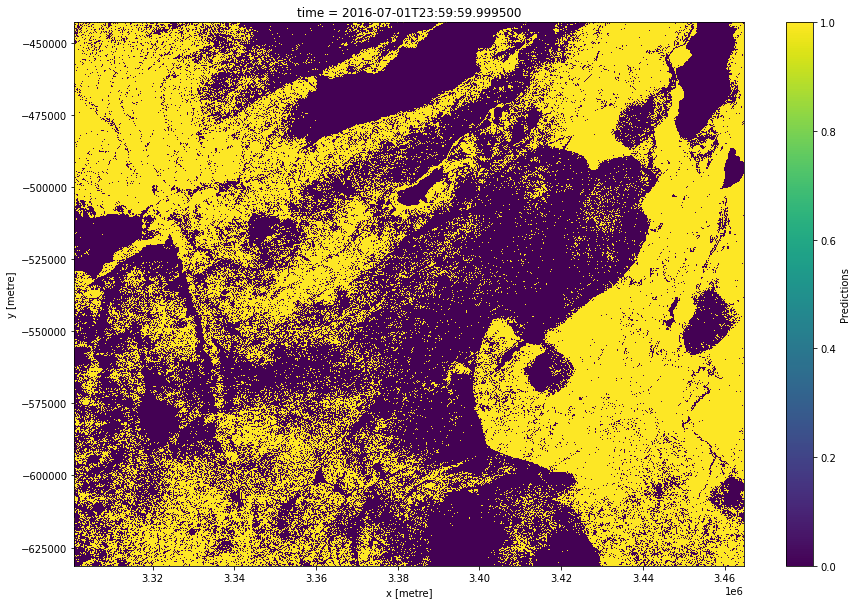

In [10]:
predict.plot(size=10)

## Next steps

To continue working through the notebooks in this `Eastern Africa Cropland Mask` workflow, go to the next notebook `5_Object-based_filtering.ipynb`.

1. [Extracting_training_data](1_Extracting_training_data.ipynb) 
2. [Inspect_training_data](2_Inspect_training_data.ipynb)
3. [Train_fit_evaluate_classifier](3_Train_fit_evaluate_classifier.ipynb)
4. **Predict (this notebook)**
5. [Object-based_filtering](5_Object-based_filtering.ipynb)


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** Dec 2020
